In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

from itertools import combinations

In [3]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [4]:
origin = load_data('mtcars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab11_/mtcars.xlsx
[desc] 자동차 32종의 11개 속성에 대한 정보를 담고 있는 데이터 (출처: R 기본 데이터)

필드    타입      설명
------  --------  --------------------------------
name    str       차종 이름 (인덱스)
mpg     str       연료 효율성 (마일 당 갤런)
cyl     category  실린더 수
disp    float     배기량 (cubic inches)
hp      float     마력 (horsepower)
drat    float     후륜축 비율 (rear axle ratio)
wt      float     차량 무게 (1000 파운드)
qsec    float     1/4 마일 달성 시간 (초)
vs      category  엔진 유형 (0: V 엔진, 1: S 엔진)
am      category  변속기 형태 (0: 자동, 1: 수동)
gear    category  전진 기어 수 (전송 기어)
carb    category  기화기 개수 (carburetors)


===== 데이터 크기 확인 =====
데이터셋 크기 : (32, 11)
열 개수: 11
행 개수: 32

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp  

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
name,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [5]:
df = origin.filter(['mpg','disp','hp','drat','wt','qsec'])
df.head()

,mpg,disp,hp,drat,wt,qsec
name,,,,,,
Mazda RX4,21.0,160.0,110,3.90,2.620,16.46
Mazda RX4 Wag,21.0,160.0,110,3.90,2.875,17.02
Datsun 710,22.8,108.0,93,3.85,2.320,18.61
Hornet 4 Drive,21.4,258.0,110,3.08,3.215,19.44
Hornet Sportabout,18.7,360.0,175,3.15,3.440,17.02


### #02. 상관분석 가정 및 시각화

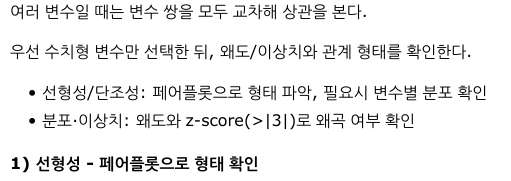

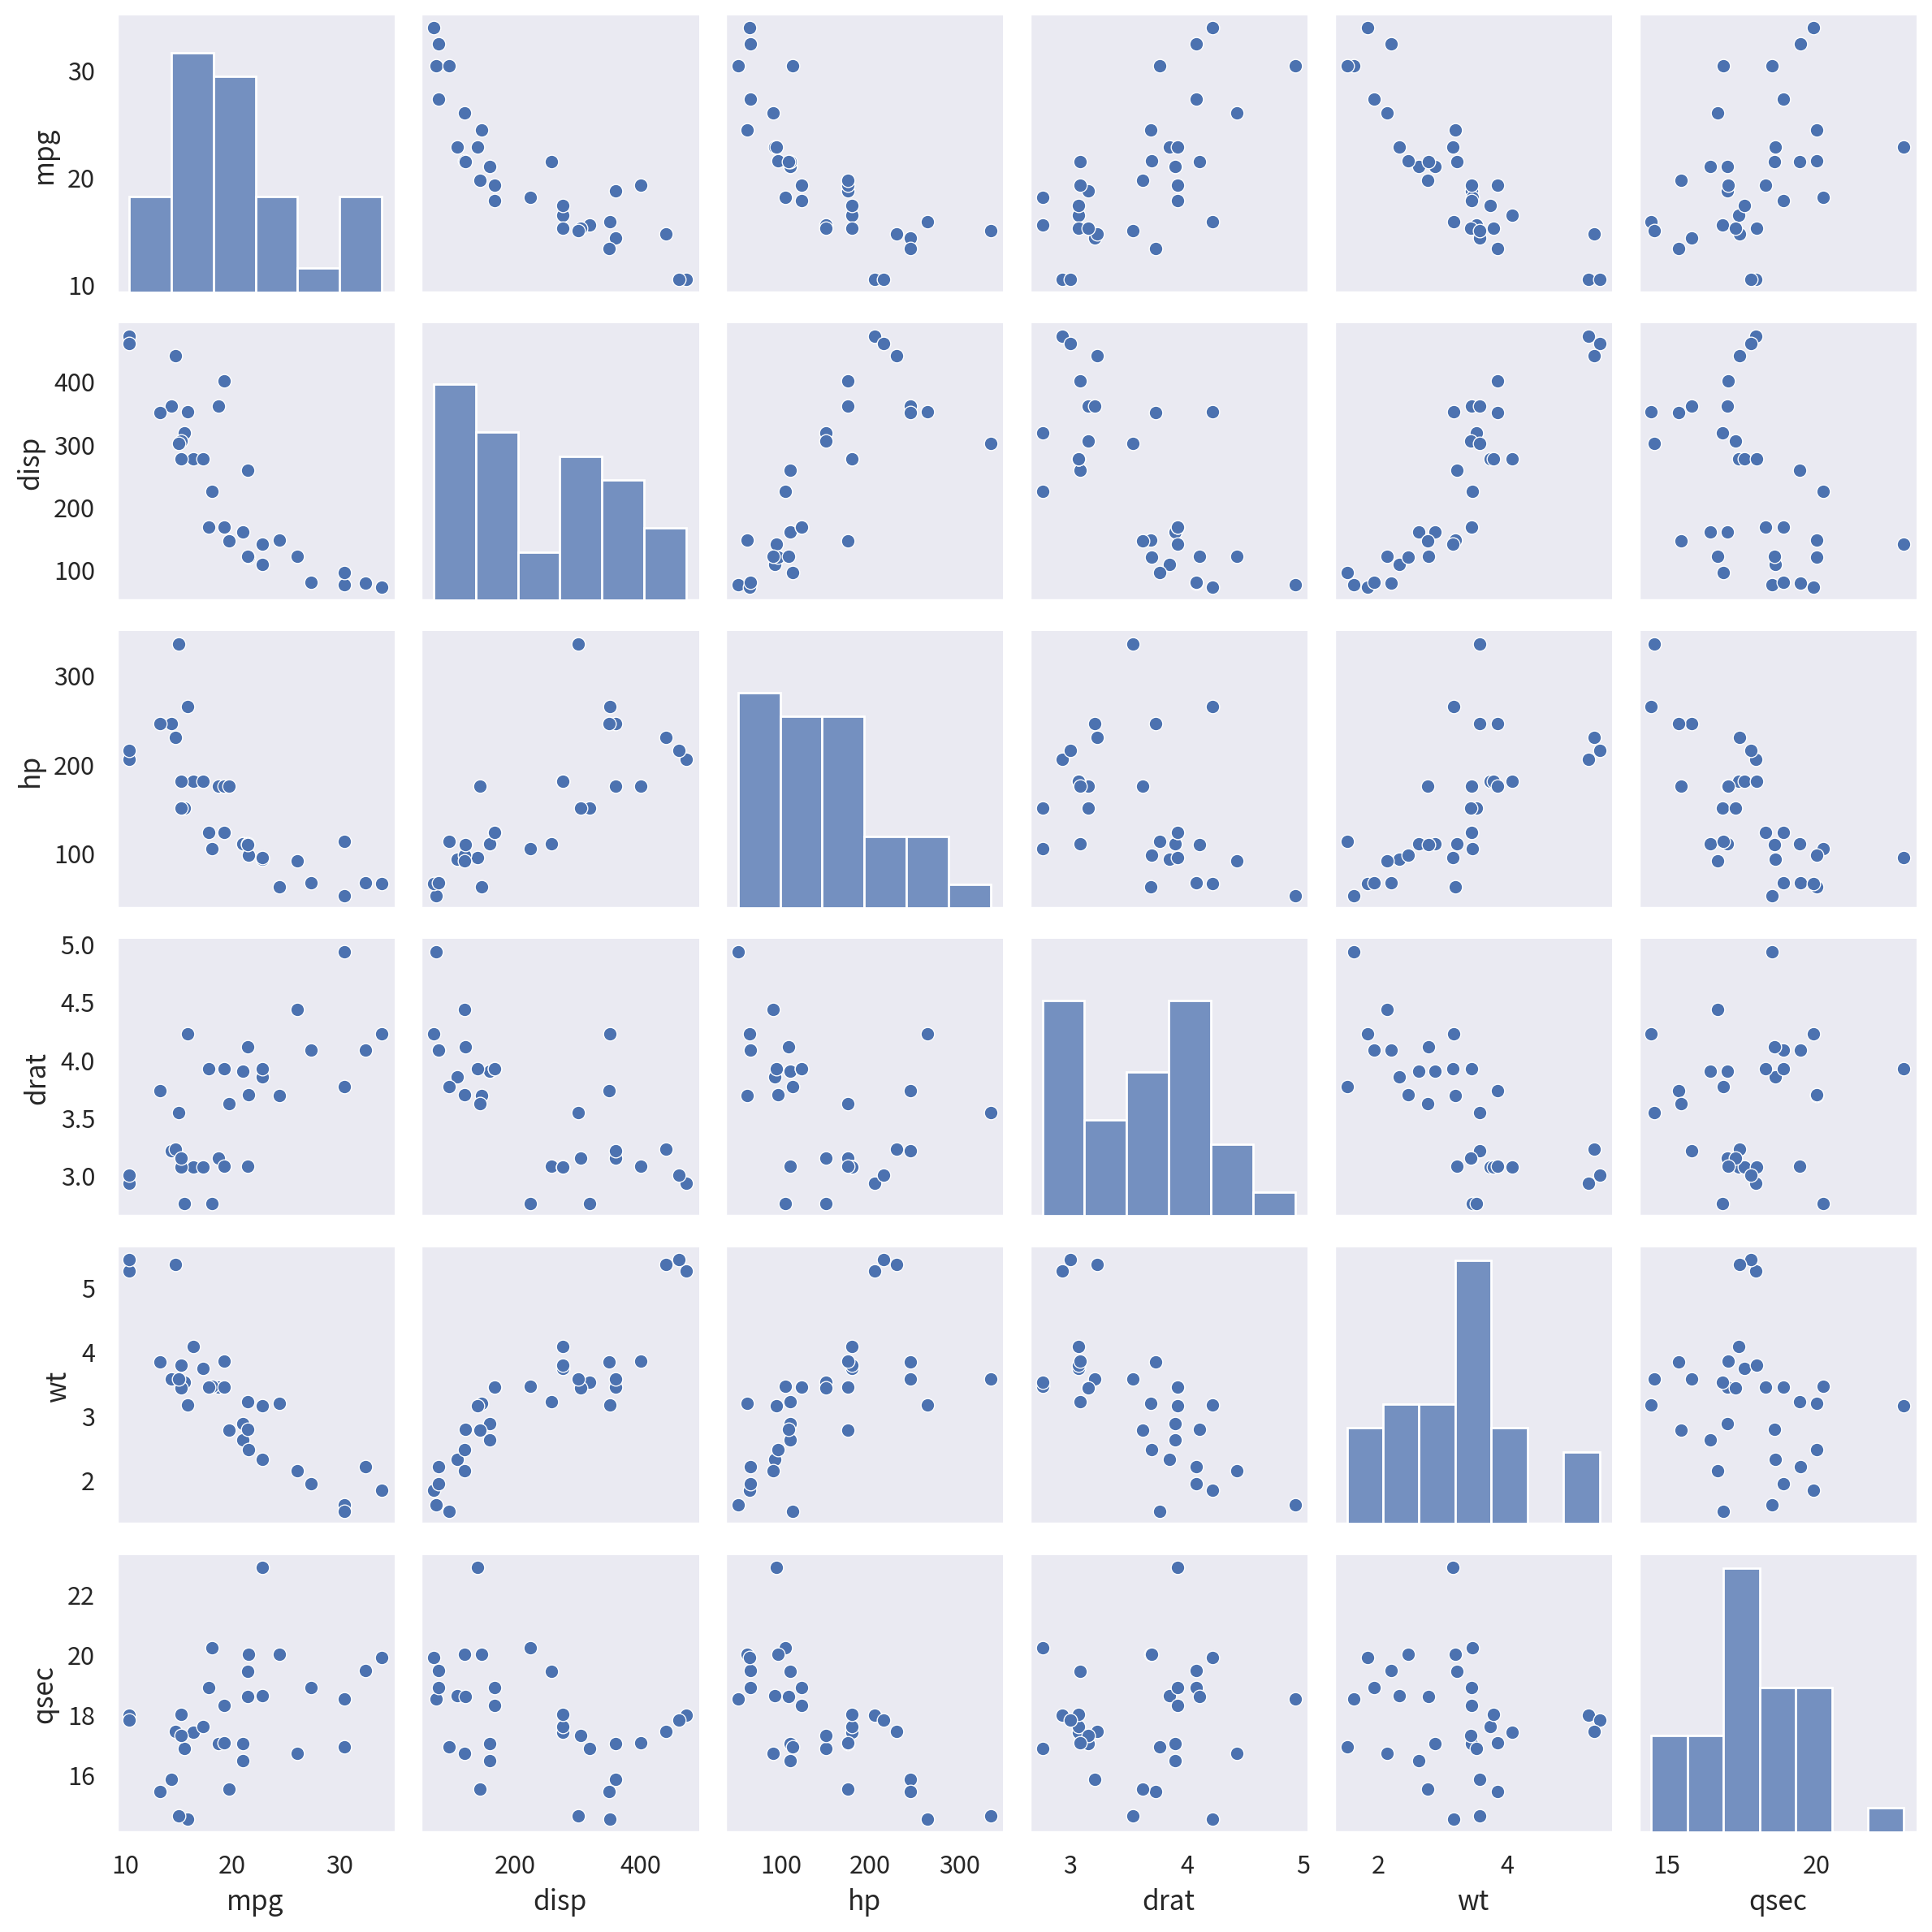

In [6]:
width_px = 2400
height_px = 2400
figsize = (width_px / my_dpi, height_px / my_dpi)

g = sb.pairplot(data=df, diag_kind='hist')
g.fig.set_size_inches(figsize)
g.fig.set_dpi(my_dpi)

plt.tight_layout()
plt.show()
plt.close()

이상치 요약

In [8]:
skew_outlier={}
for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col]= {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }
skew_outlier_df=DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z| > 3)
mpg,0.672377,-0.960191,0.0
disp,0.420233,-1.292987,0.0
hp,0.799407,-1.466775,0.0
drat,0.292780,-0.044575,0.0
wt,0.465916,-0.298323,0.0
qsec,0.406347,-0.770281,0.0


### #03. 변수 쌍별 상관 검정 및 방법 선택
- 기준 : 변수 중 하나라도 왜도 큼/이상치 있음/비선형 가능성 -> 스피어만 우선, 아니면 피어슨
- 두 계수를 모두 계산해 비교하며, 선택된 계수와 p-value를 요약한다.

In [9]:
#itertools의 combinations 함수 기능 확인 
# 주어진 리스트에서 r에 지정된 개수만큼 쌍으로 묶어 조합 가능한 모든 경우의 수를 생성
mylist = [10,20,30]
my_comb = combinations(mylist, r=2)

for c in my_comb:
    print(c)
    

(10, 20)
(10, 30)
(20, 30)


상관 분석 수행

In [11]:
rows = []

for a, b in combinations(df.columns,2):
    x = df[a]
    y = df[b]

    # [1] 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue>0.05

    # [2] 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] >0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] >0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x,y)
    else:
        chosen = 'spearman'
        corr,pval = spearmanr(x,y)

    # [4] 유의성 판단(p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # [6] 행 추가
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,mpg,disp,False,False,spearman,-0.908882,6.370336e-13,True,Very strong
1,mpg,hp,True,False,pearson,-0.776168,1.787835e-07,True,Strong
2,mpg,drat,True,False,pearson,0.681172,1.776240e-05,True,Strong
3,mpg,wt,False,False,spearman,-0.886422,1.487595e-11,True,Very strong
4,mpg,qsec,True,False,pearson,0.418684,1.708199e-02,True,Medium
5,disp,hp,True,False,pearson,0.790949,7.142679e-08,True,Strong
6,disp,drat,False,False,spearman,-0.683592,1.613884e-05,True,Strong
7,disp,wt,True,False,pearson,0.887980,1.222320e-11,True,Very strong
8,disp,qsec,True,False,pearson,-0.433698,1.314404e-02,True,Medium
9,hp,drat,False,False,spearman,-0.520125,2.277988e-03,True,Medium


3. 결과 시각화
- 상관 행렬 생성

In [ ]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r # 대칭

# 4) 대각선 (diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

# corr_matrix

width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':10})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()


,disp,drat,hp,mpg,qsec,wt
disp,1.000000,-0.683592,0.790949,-0.908882,-0.433698,0.887980
drat,-0.683592,1.000000,-0.520125,0.681172,0.091205,-0.712441
hp,0.790949,-0.520125,1.000000,-0.776168,-0.708223,0.774677
mpg,-0.908882,0.681172,-0.776168,1.000000,0.418684,-0.886422
qsec,-0.433698,0.091205,-0.708223,0.418684,1.000000,-0.174716
wt,0.887980,-0.712441,0.774677,-0.886422,-0.174716,1.000000


2) 상관 행렬 시각화(히트맵)

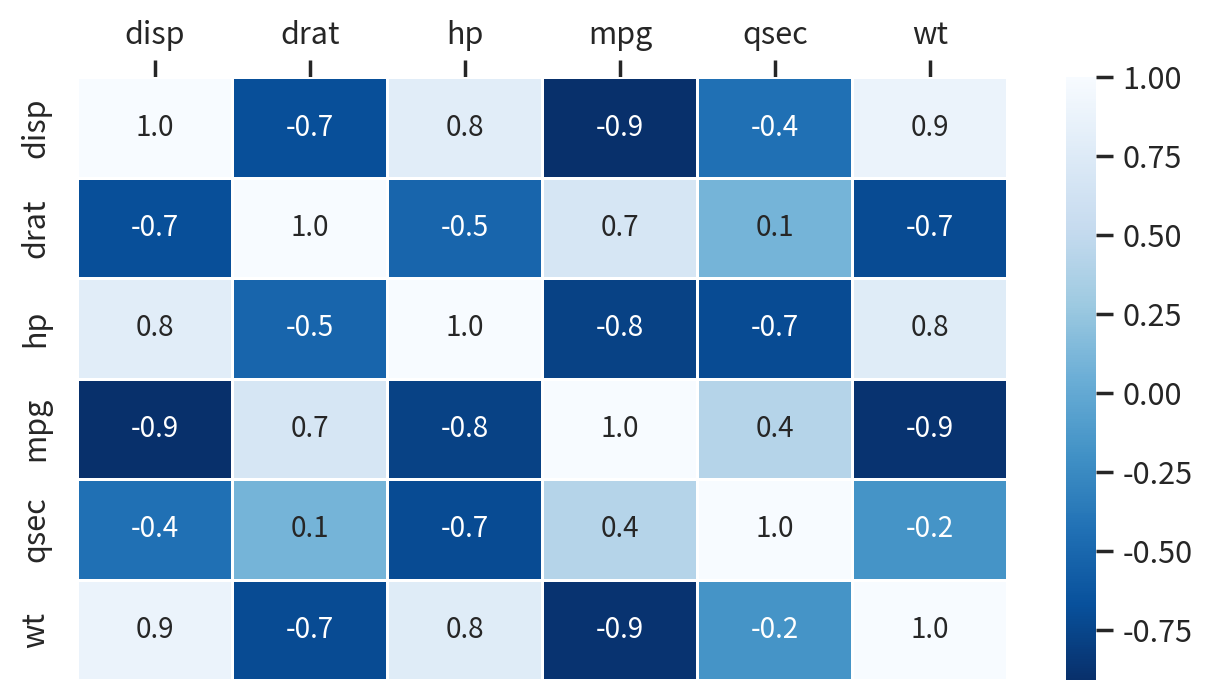

In [15]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':10})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

연습문제
---
- penguins 데이터 셋은 이터셋은 남극 Palmer 군도에서 채집된 펭귄들의 신체 특성을 포함하고 있으며, 생태학적 패턴을 이해하는 데 널리 활용된다.
- 이 데이터셋을 활용하여 펭귄의 주요 연속형 신체 측정값 간의 상관구조를 탐색하고, 부리 특성, 지느러미 및 체중 등 생물학적 특성 간의 관계를 파악하시오.

In [16]:
origin = load_data('penguins')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 데이터 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/kaggle/penguins.xlsx
[desc] 남극 팔머 군도의 펭귄 3종에 대해 신체 치수와 서식지 정보(출처: https://www.kaggle.com/datasets/larsen0966/penguins)

field              description
-----------------  -------------
species            팽귄 종
island             서식지
bill_length_mm     부리 길이
bill_depth_mm      부리 두께
flipper_length_mm  날개 길이
body_mass_g        몸무게
sex                성별


===== 데이터 크기 확인 =====
데이터셋 크기 : (334, 7)
열 개수: 7
행 개수: 334

===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   bill_length_mm     334 non-null    float64
 3   bill_depth_mm      334 non-null    float64
 4   flipper_length_mm  334 non-null    int64  
 5   body_mass_g        334 non-null    int64  
 6   sex                333 non-null    ob

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,MALE
1,Adelie,Torgersen,39.5,17.4,186,3800,FEMALE
2,Adelie,Torgersen,40.3,18.0,195,3250,FEMALE
3,Adelie,Torgersen,36.7,19.3,193,3450,FEMALE
4,Adelie,Torgersen,39.3,20.6,190,3650,MALE


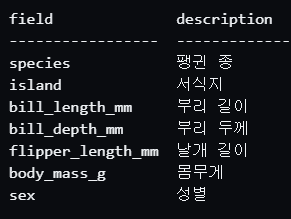


연속형 변수 : 부리 길이, 부리 두께, 날개 길이, 몸무게

In [17]:
df = origin.filter(['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'])
df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181,3750
1,39.5,17.4,186,3800
2,40.3,18.0,195,3250
3,36.7,19.3,193,3450
4,39.3,20.6,190,3650


In [18]:
skew_outlier={}
for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col]= {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count
    }
skew_outlier_df=DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z| > 3)
bill_length_mm,0.050796,-0.765943,0.0
bill_depth_mm,-0.155316,-0.732511,0.0
flipper_length_mm,0.359305,-0.791583,0.0
body_mass_g,0.471045,-2.611903,0.0


In [19]:
rows = []

for a, b in combinations(df.columns,2):
    x = df[a]
    y = df[b]

    # [1] 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue>0.05

    # [2] 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] >0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] >0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x,y)
    else:
        chosen = 'spearman'
        corr,pval = spearmanr(x,y)

    # [4] 유의성 판단(p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # [6] 행 추가
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,bill_length_mm,bill_depth_mm,False,False,spearman,-0.216209,6.782928e-05,True,Weak
1,bill_length_mm,flipper_length_mm,False,False,spearman,0.671510,3.901395e-45,True,Strong
2,bill_length_mm,body_mass_g,False,False,spearman,0.579194,2.591284e-31,True,Medium
3,bill_depth_mm,flipper_length_mm,False,False,spearman,-0.518341,2.317525e-24,True,Medium
4,bill_depth_mm,body_mass_g,False,False,spearman,-0.430729,1.609964e-16,True,Medium
5,flipper_length_mm,body_mass_g,False,False,spearman,0.841582,8.031883e-91,True,Very strong


In [ ]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r # 대칭

# 4) 대각선 (diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

# corr_matrix
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':10})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()


,bill_depth_mm,bill_length_mm,body_mass_g,flipper_length_mm
bill_depth_mm,1.000000,-0.216209,-0.430729,-0.518341
bill_length_mm,-0.216209,1.000000,0.579194,0.671510
body_mass_g,-0.430729,0.579194,1.000000,0.841582
flipper_length_mm,-0.518341,0.671510,0.841582,1.000000


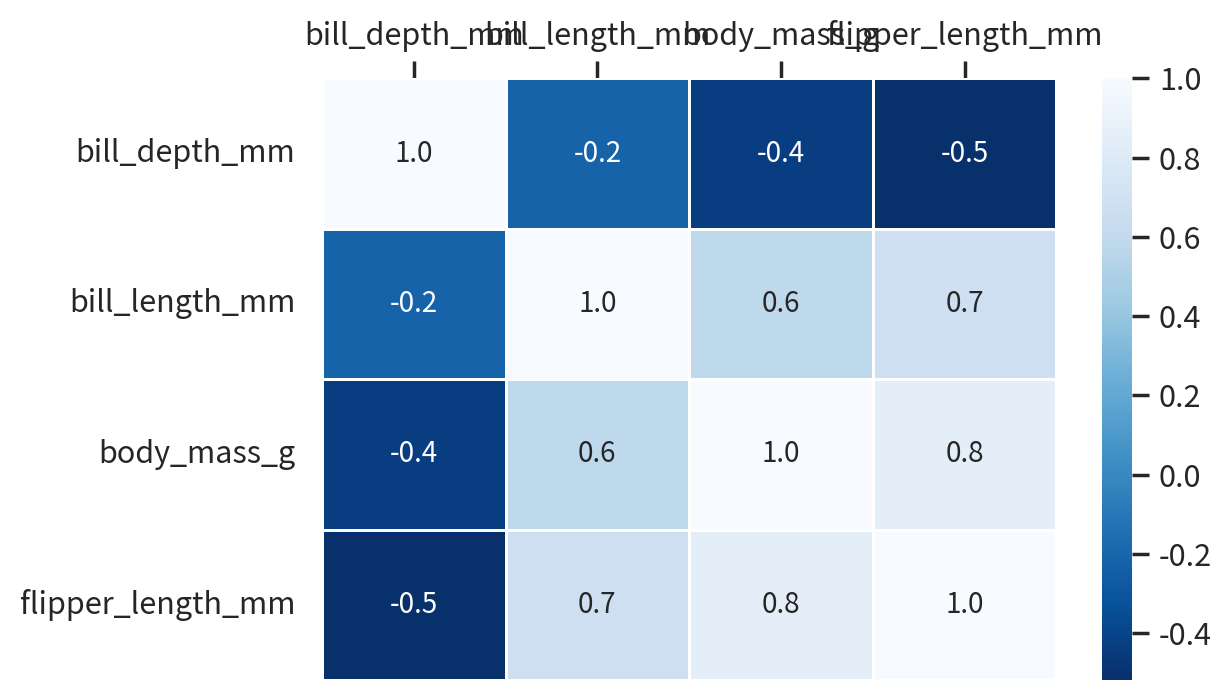

In [21]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':10})
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

plt.tight_layout()
plt.show()
plt.close()

날개 길이와 몸무게는 강한 양의 상관관계, 몸무게와 부리두께, 날개 길이와 부리 두께는 양의 상관 관계를 보여 구조적으로 연계되어 있음을 보임
- 그 외 다른 조합은 유의한 상관이 나타나지 않아 변수 간 직접적 연관성이 약함을 보여줌